# Feature Extractor on MNIST

In this notebook I'd like to use a pretrained model to extract features from the MNIST dataset. I'll use the pretrained SqueezeNet model from PyTorch's torchvision package.

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


In [10]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1
Torchvision Version:  0.14.1


In [11]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 4

# Number of epochs to train for
num_epochs = 3          #15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


In [4]:
# - Let's start by loading a pretrained model (i.e. squeezenet) and modifying the last layer to classify 10 classes instead of 1000.

# read the train csv file
train_df = pd.read_csv('../datasets/digit-recognizer/train.csv')
test_df = pd.read_csv('../datasets/digit-recognizer/test.csv')

# get the labels
labels = train_df['label'].values

# drop the label column
train_df.drop('label', axis=1, inplace=True)

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



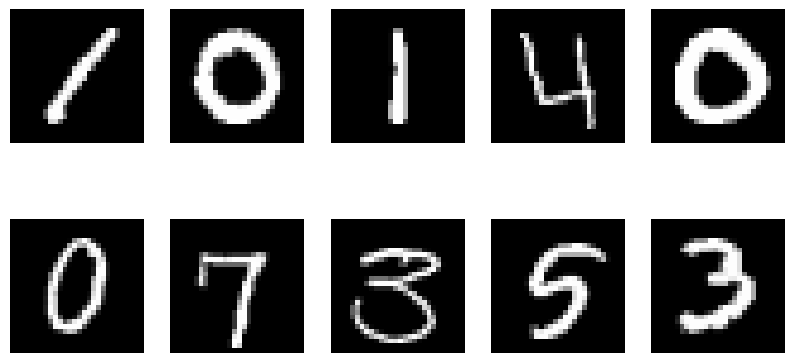

In [5]:
# get the images
images = train_df.values

# reshape the images
images = images.reshape((-1, 28, 28))

# plot some images
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(images[i*5 + j], cmap='gray')
        ax[i, j].axis('off')
plt.show()

In [7]:
# create our train and validation splits
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# print shapes of train test split
print(f'X_train.shape: {X_train.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_val.shape: {y_val.shape}')


X_train.shape: (33600, 28, 28)
X_val.shape: (8400, 28, 28)
y_train.shape: (33600,)
y_val.shape: (8400,)


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # add transform to convert grayscale to rgb
        transforms.Grayscale(num_output_channels=3),
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # add transform to convert grayscale to rgb
        transforms.Grayscale(num_output_channels=3),
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Update the train model function below to not use dataloaders
def train_model(model, x, y, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in zip(x, y):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(x)
            epoch_acc = running_corrects.double() / len(x)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

x = X_train[:5]
y = y_train[:5]

# x = torch.tensor(x, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.long)

x_0 = np.asarray(x[0], dtype=np.uint8)

# x_0 = np.asarray(x_0, dtype=np.uint8)

print(x_0.dtype, x_0.shape)

x_0 = data_transforms['train'](x_0)



# img = Image.open(input_path)

# print(f'img.shape before transform: {img.size}')

# # Use torch data transform to resize image
# img = data_transforms['val'](img)

# Train and evaluate
# model_ft, hist = train_model(model_ft, x, y, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


In [ ]:
# Initialize the model for this run
num_classes = 10    # 10 classes for digits 0-9 of MNIST dataset
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

# put model in training mode
model_ft.train()

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [14]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

x = X_train[:5]
y = y_train[:5]

print(num_epochs)

# Train and evaluate
model_ft, hist = train_model(model_ft, x, y, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


3


NameError: name 'model_ft' is not defined